In [125]:
%run 'Data Cleaning.ipynb'

In [138]:
jobs_cleaned.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,work_type,currency,compensation_type,scraped,skill_name,industry_name,title_enc,location_enc,skill_name_enc,formatted_experience_level_enc
6,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,240895.0,205956.0,YEARLY,Full-time,United States,...,FULL_TIME,USD,BASE_SALARY,1699085346,Information Technology,"Technology, Information and Internet",3620,1591,16,5
7,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,240895.0,205956.0,YEARLY,Full-time,United States,...,FULL_TIME,USD,BASE_SALARY,1699085346,Information Technology,Manufacturing,3620,1591,16,5
8,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,240895.0,205956.0,YEARLY,Full-time,United States,...,FULL_TIME,USD,BASE_SALARY,1699085346,Information Technology,Retail,3620,1591,16,5
21,3757935381,19181907.0,Insights Analyst - Auto Industry,Who We Are\n\nEscalent is an award-winning dat...,64000.0,61000.0,58000.0,YEARLY,Full-time,United States,...,FULL_TIME,USD,BASE_SALARY,1699134111,Information Technology,Market Research,2566,1591,16,2
22,3757935381,19181907.0,Insights Analyst - Auto Industry,Who We Are\n\nEscalent is an award-winning dat...,64000.0,61000.0,58000.0,YEARLY,Full-time,United States,...,FULL_TIME,USD,BASE_SALARY,1699134111,Research,Market Research,2566,1591,28,2


In [140]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

med_P = np.nanpercentile(jobs_cleaned['med_salary'], [1, 99])
jobs_cleaned = jobs_cleaned[(jobs_cleaned['med_salary'] > med_P[0]) & (jobs_cleaned['med_salary'] < med_P[1])]

min_P = np.nanpercentile(jobs_cleaned['min_salary'], [1, 99])
jobs_cleaned = jobs_cleaned[(jobs_cleaned['min_salary'] > min_P[0]) & (jobs_cleaned['min_salary'] < min_P[1])]

max_P = np.nanpercentile(jobs_cleaned['max_salary'], [1, 99])
jobs_cleaned = jobs_cleaned[(jobs_cleaned['min_salary'] > max_P[0]) & (jobs_cleaned['min_salary'] < max_P[1])]

# Create a new LabelEncoder for each categorical column
title_encoder = LabelEncoder()
location_encoder = LabelEncoder()
skill_name_encoder = LabelEncoder()
experience_level_encoder = LabelEncoder()

# Fit and transform each column with its respective encoder
jobs_cleaned['title_enc'] = title_encoder.fit_transform(jobs_cleaned['title'])
jobs_cleaned['location_enc'] = location_encoder.fit_transform(jobs_cleaned['location'])
jobs_cleaned['skill_name_enc'] = skill_name_encoder.fit_transform(jobs_cleaned['skill_name'])
jobs_cleaned['formatted_experience_level_enc'] = experience_level_encoder.fit_transform(jobs_cleaned['formatted_experience_level'])


X = jobs_cleaned[['title_enc', 'location_enc','skill_name_enc','formatted_experience_level_enc']]


jobs_cleaned.to_csv('jobs_cleaned.csv')

## XGBoost

In [121]:
def train_salary_model(salary_level):
    # Select the salary level for prediction
    y = jobs_cleaned[salary_level]
    
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Initializing and training the XGBoost regressor model
    # After running a few grid searches I found that each model had the same best parameters
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2,
                              max_depth = 5, n_estimators = 1000)
    xg_reg.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = xg_reg.predict(X_test)

    # Calculating the RMSE for the predictions
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    
    # Returning the trained model
    return xg_reg, salary_level, y_test, y_pred, rmse

In [122]:
def model_eval(model, salary_level, y_test, y_pred, rmse):

    print(f"Salary Level: {salary_level}")
    print(f"RMSE: {rmse}")
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Salaries')
    plt.ylabel('Predicted Salaries')
    plt.title(f'Actual vs. Predicted Salaries ({salary_level})')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.show()

Salary Level: min_salary
RMSE: 13364.273213554827


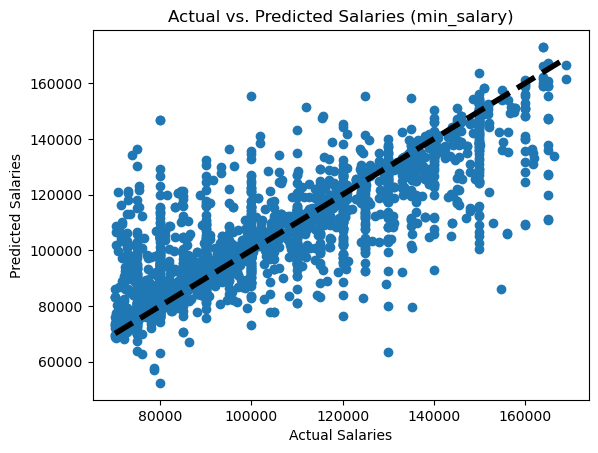

Salary Level: max_salary
RMSE: 22733.219146847896


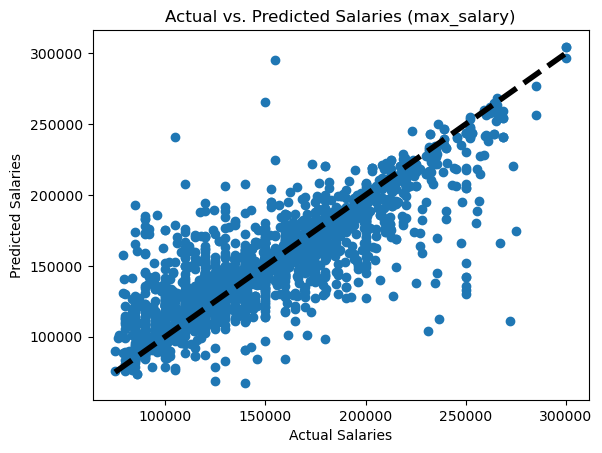

Salary Level: med_salary
RMSE: 16308.90832873758


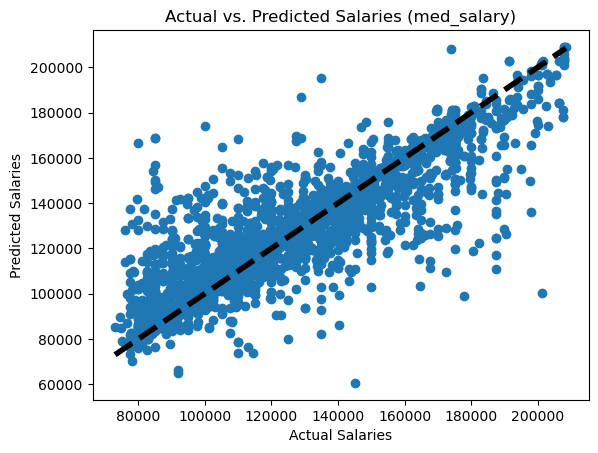

In [123]:
models = ['min_salary','max_salary','med_salary']
for model in models:
    model_eval(*train_salary_model(model))

In [117]:
import pickle

med_salary_model, _, _, _, _ = train_salary_model('med_salary')
min_salary_model, _, _, _, _ = train_salary_model('min_salary')
max_salary_model, _, _, _, _ = train_salary_model('max_salary')

med_filename = 'median_model.sav'
min_filename = 'min_model.sav'
max_filename = 'max_model.sav'

pickle.dump(med_salary_model, open(med_filename, 'wb'))
pickle.dump(min_salary_model, open(min_filename, 'wb'))
pickle.dump(max_salary_model, open(max_filename, 'wb'))

loaded_med_model = pickle.load(open(med_filename, 'rb'))
loaded_min_model = pickle.load(open(min_filename, 'rb'))
loaded_max_model = pickle.load(open(max_filename, 'rb'))

### Min, Median, Max estimator

In [109]:
med_salary_model, _, _, _, _ = train_salary_model('med_salary')
min_salary_model, _, _, _, _ = train_salary_model('min_salary')
max_salary_model, _, _, _, _ = train_salary_model('max_salary')

# Example user input
for location in jobs_cleaned['location'].unique():
    user_input = {
        'title_enc': ['Data Scientist'],
        'location_enc': [f'{location}'],
        'skill_name_enc': ['Information Technology'],
        'formatted_experience_level_enc': ['Mid-Senior level']
    }

    user_input_df = pd.DataFrame(user_input)

    user_input_df['title_enc'] = title_encoder.transform(user_input_df['title_enc'])
    user_input_df['location_enc'] = location_encoder.transform(user_input_df['location_enc'])
    user_input_df['skill_name_enc'] = skill_name_encoder.transform(user_input_df['skill_name_enc'])
    user_input_df['formatted_experience_level_enc'] = experience_level_encoder.transform(user_input_df['formatted_experience_level_enc'])

    # Predict the salary for the user input
    min_predicted_salary = min_salary_model.predict(user_input_df)
    median_predicted_salary = med_salary_model.predict(user_input_df)
    max_predicted_salary = max_salary_model.predict(user_input_df)

    print(f"----{location}-----")
    print(f"\n Estimated salary: ${min_predicted_salary[0]:,.2f} - ${median_predicted_salary[0]:,.2f} - ${max_predicted_salary[0]:,.2f} \n")

----United States-----

 Estimated salary: $173,930.30 - $183,780.94 - $197,439.11 

----Coeur d'Alene, ID-----

 Estimated salary: $127,355.34 - $156,723.31 - $170,532.81 

----Waukesha, WI-----

 Estimated salary: $147,533.12 - $149,743.92 - $170,604.33 

----Orlando, FL-----

 Estimated salary: $123,336.18 - $152,384.77 - $168,102.91 

----Oakland, CA-----

 Estimated salary: $140,964.92 - $155,597.81 - $170,635.92 

----Broomfield, CO-----

 Estimated salary: $108,193.84 - $134,934.58 - $180,081.42 

----Swedesboro, NJ-----

 Estimated salary: $146,231.19 - $158,438.56 - $196,604.19 

----Richmond, VA-----

 Estimated salary: $133,105.95 - $164,786.02 - $166,268.08 

----Rapid City, SD-----

 Estimated salary: $117,762.38 - $151,126.89 - $223,242.33 

----Yuma, AZ-----

 Estimated salary: $130,032.95 - $148,904.69 - $196,684.61 

----Sheboygan, WI-----

 Estimated salary: $131,443.12 - $161,516.41 - $195,783.55 

----Portland, OR-----

 Estimated salary: $131,125.45 - $156,164.64 -

----Edmond, OK-----

 Estimated salary: $129,466.95 - $163,171.53 - $187,542.66 

----Las Vegas, NV-----

 Estimated salary: $133,613.66 - $157,507.84 - $187,829.19 

----Fort Morgan, CO-----

 Estimated salary: $134,046.38 - $181,617.98 - $229,348.41 

----Chandler, AZ-----

 Estimated salary: $117,661.90 - $157,361.81 - $193,228.42 

----Sandy, UT-----

 Estimated salary: $168,404.11 - $204,373.44 - $234,744.25 

----North Las Vegas, NV-----

 Estimated salary: $116,297.08 - $144,567.88 - $162,616.42 

----Plano, TX-----

 Estimated salary: $133,650.45 - $153,721.25 - $180,293.58 

----Sunnyvale, CA-----

 Estimated salary: $146,231.19 - $158,438.56 - $196,604.19 

----Baltimore County, MD-----

 Estimated salary: $104,571.72 - $140,376.23 - $173,878.05 

----Los Angeles, California, United States-----

 Estimated salary: $129,752.91 - $145,193.20 - $165,955.31 

----San Francisco Bay Area-----

 Estimated salary: $148,400.33 - $190,571.17 - $206,578.38 

----McLean, VA-----

 Estima

----Albuquerque, NM-----

 Estimated salary: $86,390.20 - $117,135.88 - $145,083.88 

----Hartford, CT-----

 Estimated salary: $134,678.70 - $162,257.23 - $186,655.73 

----West Coxsackie, NY-----

 Estimated salary: $148,973.41 - $159,810.42 - $170,929.67 

----Merced, CA-----

 Estimated salary: $131,973.78 - $167,911.91 - $176,860.69 

----Illinois, United States-----

 Estimated salary: $126,662.09 - $157,597.70 - $195,310.23 

----Akron, OH-----

 Estimated salary: $73,416.92 - $95,775.41 - $127,324.94 

----Sterling, VA-----

 Estimated salary: $126,988.19 - $139,840.88 - $168,057.02 

----Indiana, United States-----

 Estimated salary: $130,176.18 - $154,160.39 - $185,460.83 

----Santa Cruz County, CA-----

 Estimated salary: $128,513.20 - $160,622.48 - $196,583.16 

----Crete, NE-----

 Estimated salary: $129,407.00 - $205,280.75 - $244,688.09 

----Euless, TX-----

 Estimated salary: $108,633.27 - $134,441.09 - $154,873.42 

----Bradenton, FL-----

 Estimated salary: $117,74

----Cornelia, GA-----

 Estimated salary: $130,100.03 - $188,618.59 - $236,603.33 

----Franklin, NC-----

 Estimated salary: $120,569.38 - $155,312.88 - $189,155.64 

----Albemarle, NC-----

 Estimated salary: $86,390.20 - $117,135.88 - $145,083.88 

----Hobbs, NM-----

 Estimated salary: $122,660.70 - $143,445.59 - $184,898.67 

----Somersworth, NH-----

 Estimated salary: $126,958.48 - $156,959.25 - $188,377.28 

----Tilton, NH-----

 Estimated salary: $149,182.50 - $153,281.75 - $179,113.77 

----Dunwoody, GA-----

 Estimated salary: $137,622.86 - $172,169.03 - $196,390.91 

----Mechanicsville, VA-----

 Estimated salary: $129,617.26 - $167,623.97 - $193,041.92 

----North Myrtle Beach, SC-----

 Estimated salary: $116,297.08 - $144,567.88 - $162,616.42 

----Norcross, GA-----

 Estimated salary: $116,284.30 - $150,766.05 - $192,386.55 

----Middlebury, VT-----

 Estimated salary: $119,332.37 - $158,414.34 - $177,155.25 

----Chevy Chase, MD-----

 Estimated salary: $112,339.75 - $

----Kennesaw, GA-----

 Estimated salary: $118,189.78 - $152,996.91 - $189,010.95 

----Nicholls, GA-----

 Estimated salary: $116,284.30 - $150,766.05 - $192,386.55 

----Medford, MA-----

 Estimated salary: $129,617.26 - $167,623.97 - $193,041.92 

----Modesto, CA-----

 Estimated salary: $121,826.42 - $147,945.81 - $153,773.17 

----Dexter, MI-----

 Estimated salary: $134,722.59 - $168,375.11 - $201,439.58 

----Connecticut, United States-----

 Estimated salary: $126,815.79 - $170,863.23 - $208,073.16 

----Glendale, AZ-----

 Estimated salary: $122,541.85 - $147,604.19 - $171,376.38 

----Tustin, CA-----

 Estimated salary: $165,553.14 - $181,750.19 - $204,207.34 

----Blackwood, NJ-----

 Estimated salary: $100,868.30 - $135,049.20 - $169,283.88 

----Greater New Orleans Region-----

 Estimated salary: $130,839.25 - $154,314.47 - $179,109.00 

----La Jolla, California, United States-----

 Estimated salary: $127,564.12 - $157,557.36 - $190,237.88 

----Maitland, FL-----

 Estima

----Dover, DE-----

 Estimated salary: $134,722.59 - $168,375.11 - $201,439.58 

----Manhattan, KS-----

 Estimated salary: $133,073.20 - $161,096.02 - $177,792.95 

----Dallas-Fort Worth Metroplex-----

 Estimated salary: $142,341.02 - $190,583.58 - $231,464.69 

----Livonia, MI-----

 Estimated salary: $128,106.04 - $151,754.34 - $166,069.47 

----Wilmington, NC-----

 Estimated salary: $134,846.31 - $152,832.67 - $229,098.22 

----Edison, NJ-----

 Estimated salary: $129,466.95 - $163,171.53 - $187,542.66 

----Rochester, New York Metropolitan Area-----

 Estimated salary: $121,329.41 - $141,003.39 - $159,291.78 

----Pittsburg, CA-----

 Estimated salary: $133,897.31 - $152,727.02 - $178,774.17 

----Farmington, ME-----

 Estimated salary: $116,981.00 - $141,106.17 - $153,007.28 

----Bristol, CT-----

 Estimated salary: $127,025.68 - $158,607.41 - $193,251.05 

----Charleston, WV-----

 Estimated salary: $117,429.16 - $165,423.73 - $186,491.22 

----Coral Springs, FL-----

 Estima

----Avon, MA-----

 Estimated salary: $102,234.36 - $133,860.44 - $165,036.28 

----Greensboro, NC-----

 Estimated salary: $130,992.86 - $159,013.52 - $181,179.19 

----Bedford Park, IL-----

 Estimated salary: $110,327.68 - $145,008.78 - $186,037.42 

----Wellesley, MA-----

 Estimated salary: $148,973.41 - $159,810.42 - $170,929.67 

----Thomasville, GA-----

 Estimated salary: $154,014.47 - $168,576.91 - $195,243.84 

----Gainesville, GA-----

 Estimated salary: $127,997.59 - $155,527.69 - $187,004.81 

----Newton, MA-----

 Estimated salary: $116,284.30 - $150,766.05 - $192,386.55 

----Calistoga, CA-----

 Estimated salary: $123,756.05 - $165,877.52 - $206,670.95 

----Westminster, CO-----

 Estimated salary: $158,164.22 - $173,669.20 - $220,280.75 

----Coconut Creek, FL-----

 Estimated salary: $127,355.34 - $156,723.31 - $170,532.81 

----Fort Lawn, SC-----

 Estimated salary: $134,046.38 - $181,617.98 - $229,348.41 

----Arizona, United States-----

 Estimated salary: $97,932

----Baldwin Park, CA-----

 Estimated salary: $104,571.72 - $140,376.23 - $173,878.05 

----Bunnell, FL-----

 Estimated salary: $109,829.01 - $144,452.06 - $185,157.17 

----Des Moines Metropolitan Area-----

 Estimated salary: $130,122.20 - $165,114.22 - $179,131.70 

----Nyack, NY-----

 Estimated salary: $116,343.34 - $141,982.52 - $160,328.25 

----Salem, MA-----

 Estimated salary: $111,388.12 - $133,631.45 - $153,206.72 

----Livermore, CA-----

 Estimated salary: $128,106.04 - $151,754.34 - $166,069.47 

----Hire, IL-----

 Estimated salary: $128,704.08 - $152,483.44 - $168,901.22 

----West Mifflin, PA-----

 Estimated salary: $148,973.41 - $159,810.42 - $170,929.67 

----Perth Amboy, NJ-----

 Estimated salary: $119,613.59 - $145,683.94 - $165,488.39 

----Brook Park, OH-----

 Estimated salary: $127,025.68 - $158,607.41 - $193,251.05 

----Niskayuna, NY-----

 Estimated salary: $116,284.30 - $150,766.05 - $192,386.55 

----Newtown Square, PA-----

 Estimated salary: $116,284

----East Hampton, NY-----

 Estimated salary: $125,402.63 - $161,423.70 - $192,410.53 

----Lehi, UT-----

 Estimated salary: $128,783.47 - $155,895.78 - $191,543.00 

----Roselle, IL-----

 Estimated salary: $121,329.41 - $141,003.39 - $159,291.78 

----Hicksville, NY-----

 Estimated salary: $128,704.08 - $152,483.44 - $168,901.22 

----Fort Smith, AR-----

 Estimated salary: $129,111.12 - $177,687.81 - $208,433.39 

----Exton, PA-----

 Estimated salary: $108,633.27 - $134,441.09 - $154,873.42 

----Grand Prairie, TX-----

 Estimated salary: $122,998.59 - $143,325.66 - $168,021.84 

----Schaumburg, IL-----

 Estimated salary: $131,299.00 - $158,978.31 - $194,800.58 

----Carmel, CA-----

 Estimated salary: $119,466.60 - $160,765.27 - $185,221.42 

----Tahoe City, CA-----

 Estimated salary: $139,414.58 - $150,634.56 - $193,179.78 

----Great Barrington, MA-----

 Estimated salary: $121,726.27 - $139,410.73 - $159,028.33 

----Dothan, AL-----

 Estimated salary: $134,722.59 - $168,37

----Brownsville, TX-----

 Estimated salary: $108,193.84 - $134,934.58 - $180,081.42 

----West Point, GA-----

 Estimated salary: $158,164.22 - $173,669.20 - $220,280.75 

----Carlstadt, NJ-----

 Estimated salary: $119,466.60 - $160,765.27 - $185,221.42 

----Gap, PA-----

 Estimated salary: $127,997.59 - $155,527.69 - $187,004.81 

----Germantown, MD-----

 Estimated salary: $122,541.85 - $147,604.19 - $171,376.38 

----Bayonne, NJ-----

 Estimated salary: $110,327.68 - $145,008.78 - $186,037.42 

----Barre, MA-----

 Estimated salary: $104,571.72 - $140,376.23 - $173,878.05 

----Little Falls, NJ-----

 Estimated salary: $130,870.71 - $164,156.64 - $193,988.80 

----Belmont, WI-----

 Estimated salary: $104,884.97 - $146,513.94 - $190,065.33 

----Alexandria, LA-----

 Estimated salary: $86,390.20 - $117,135.88 - $145,083.88 

----Seminole, FL-----

 Estimated salary: $131,443.12 - $161,516.41 - $195,783.55 

----Mystic, CT-----

 Estimated salary: $156,883.77 - $186,944.12 - $210,

----Grandville, MI-----

 Estimated salary: $121,726.27 - $139,410.73 - $159,028.33 

----New Hampshire, United States-----

 Estimated salary: $115,568.20 - $133,857.44 - $149,213.45 

----Arkansas, United States-----

 Estimated salary: $97,932.30 - $135,463.30 - $169,738.33 

----Portland, TX-----

 Estimated salary: $131,125.45 - $156,164.64 - $182,847.69 

----El Monte, CA-----

 Estimated salary: $129,466.95 - $163,171.53 - $187,542.66 

----Dartmouth, MA-----

 Estimated salary: $142,341.02 - $190,583.58 - $231,464.69 

----Bethpage, NY-----

 Estimated salary: $108,820.48 - $147,506.11 - $185,787.14 

----Jeffersonville, IN-----

 Estimated salary: $117,920.46 - $143,333.56 - $169,496.80 

----McPherson, KS-----

 Estimated salary: $129,617.26 - $167,623.97 - $193,041.92 

----Cottage Grove, OR-----

 Estimated salary: $129,407.00 - $205,280.75 - $244,688.09 

----Woodland, CA-----

 Estimated salary: $141,401.67 - $156,738.38 - $206,023.36 

----Hagerstown, MD-----

 Estimated

----Pine Bluff, AR-----

 Estimated salary: $133,897.31 - $152,727.02 - $178,774.17 

----Janesville, WI-----

 Estimated salary: $117,920.46 - $143,333.56 - $169,496.80 

----Cuyahoga Falls, OH-----

 Estimated salary: $134,342.58 - $198,986.72 - $231,231.45 

----Scottsbluff, NE-----

 Estimated salary: $127,804.44 - $151,662.95 - $180,384.83 

----West Long Branch, NJ-----

 Estimated salary: $148,973.41 - $159,810.42 - $170,929.67 

----Athens, OH-----

 Estimated salary: $96,432.18 - $136,062.48 - $181,658.92 

----Hilton Head Island, South Carolina Area-----

 Estimated salary: $128,704.08 - $152,483.44 - $168,901.22 

----Red Bank, NJ-----

 Estimated salary: $117,762.38 - $151,126.89 - $223,242.33 

----West Chicago, IL-----

 Estimated salary: $148,973.41 - $159,810.42 - $170,929.67 

----St Helena, CA-----

 Estimated salary: $107,696.31 - $138,555.17 - $170,089.58 

----Hermitage, PA-----

 Estimated salary: $128,704.08 - $152,483.44 - $168,901.22 

----Great Falls, MT-----


----Macon, GA-----

 Estimated salary: $132,726.39 - $158,643.45 - $176,820.88 

----Hilton Head Island, SC-----

 Estimated salary: $128,704.08 - $152,483.44 - $168,901.22 

----Hugo, MN-----

 Estimated salary: $134,778.42 - $159,467.75 - $188,286.47 

----Reading, PA-----

 Estimated salary: $117,762.38 - $151,126.89 - $223,242.33 

----Selah, WA-----

 Estimated salary: $131,443.12 - $161,516.41 - $195,783.55 

----Port Arthur, TX-----

 Estimated salary: $129,397.02 - $152,838.83 - $178,899.89 

----Belton, MO-----

 Estimated salary: $104,884.97 - $146,513.94 - $190,065.33 

----El Cajon, CA-----

 Estimated salary: $129,466.95 - $163,171.53 - $187,542.66 

----Hollister, CA-----

 Estimated salary: $122,660.70 - $143,445.59 - $184,898.67 

----Billings, MT-----

 Estimated salary: $108,820.48 - $147,506.11 - $185,787.14 

----Davis, CA-----

 Estimated salary: $142,341.02 - $190,583.58 - $231,464.69 

----Greater Bangor Area-----

 Estimated salary: $121,726.27 - $139,410.73 - $

### Job Title Similarity Search

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# List of job titles
job_titles = jobs_cleaned['title'].unique()

# User input job title
user_input_title = input("Enter job title: ")

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the job titles to TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(job_titles)

# Transform the user input job title to TF-IDF vector
user_input_vector = tfidf_vectorizer.transform([user_input_title])

# Compute the cosine similarity between user input job title and each job title in the list
cos_similarity = cosine_similarity(user_input_vector, tfidf_matrix)[0]

# Find the indices of the top 5 cosine similarity scores
top_5_indices = np.argsort(cos_similarity)[-5:]

# Find the most similar job titles in the list
most_similar_job_titles = job_titles[top_5_indices]

# Reverse the array to have the most similar first
most_similar_job_titles = np.flip(most_similar_job_titles)

print("The top 5 most similar job titles are:", most_similar_job_titles)


Enter job title: data analyst
The top 5 most similar job titles are: ['Data Analyst' 'Senior Data Analyst' 'Business Data Analyst'
 'Product Data Analyst' 'Healthcare Data Analyst']


### Job Description Similarity Search

In [111]:
jobs = jobs_cleaned[['title','description']]
job_descriptions = jobs['description'].tolist()  # Use list for maintaining order
job_titles = jobs['title'].tolist()  # This will not be used directly but ensures we're aligned with descriptions

# User input job description
user_input_description = """
I want to use SQL and Python to build data visualizations and solve problems with data analysis
"""

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the job descriptions to TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(job_descriptions)

# Transform the user input job description to TF-IDF vector
user_input_vector = tfidf_vectorizer.transform([user_input_description])

# Compute the cosine similarity between user input job description and each job description in the list
cos_similarity = cosine_similarity(user_input_vector, tfidf_matrix)[0]

# Find the indices of the top 5 cosine similarity scores
top_5_indices = np.argsort(cos_similarity)[-5:]

# Retrieve the job titles corresponding to these top 5 indices from the original DataFrame
most_similar_job_titles = [jobs.iloc[i]['title'] for i in top_5_indices]

# Reverse the list to have the most similar first
most_similar_job_titles.reverse()

print("The top 5 most related job titles are:", most_similar_job_titles)

The top 5 most related job titles are: ['Data Analyst', 'Senior Data Engineer', 'IT Data Warehouse Analyst', 'Data Analytics Audit Associate', 'Data Analytics Audit Associate']


# Catboost Regressor

In [112]:
# from feature_engine.encoding import RareLabelEncoder

# # select label
# df = jobs_cleaned[['title','location','skill_name','med_salary','formatted_experience_level','industry_name']]
# main_label = 'med_salary'
# # Exclude 1% of smallest and 1% of highest values
# P = np.percentile(df[main_label], [1, 99])
# df = df[(df[main_label] > P[0]) & (df[main_label] < P[1])]

# # log10-transform columns and group by larger bins
# def log10_transform(x):
#     try: 
#         return str(round(1/5*round(5*np.log10(1+x)),1))
#     except:
#         return 'None'
# # set up the rare label encoder limiting number of categories to max_n_categories
# for col in ['title','location','skill_name','formatted_experience_level','industry_name']:
#     df[col] = df[col].fillna('None')
#     encoder = RareLabelEncoder(n_categories=1, max_n_categories=50, replace_with='Other', tol=10.0/df.shape[0])
#     df[col] = encoder.fit_transform(df[[col]])
# print(df.shape)
# df.sample(5).T

In [113]:
# # initialize data
# y = df[main_label].values.reshape(-1,)
# X = df[['title','location','skill_name','formatted_experience_level','industry_name']]
# cat_cols = df.select_dtypes(include=['object']).columns
# cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
# X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=df[['title']])
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [114]:
# from catboost import Pool, CatBoostRegressor

# # initialize Pool
# train_pool = Pool(X_train, 
#                   y_train, 
#                   cat_features=cat_cols_idx)
# test_pool = Pool(X_test,
#                  y_test,
#                  cat_features=cat_cols_idx)
# # specify the training parameters 
# model = CatBoostRegressor(iterations=2000, 
#                           depth=5,
#                           verbose=0,
#                           learning_rate=0.01, 
#                           loss_function='RMSE')
# #train the model
# model.fit(train_pool)
# # make the prediction using the resulting model
# y_train_pred = model.predict(train_pool)
# y_test_pred = model.predict(test_pool)

# rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
# rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
# print(f"RMSE score for train {round(rmse_train,3)} USD/year, and for test {round(rmse_test,3)} USD/year")

In [115]:
# # Example user input
# for location in jobs_cleaned['location'].unique():
#     user_input = {
#         'title': ['Data Scientist'],
#         'location': [f'{location}'],
#         'skill_name': ['Information Technology'],
#         'formatted_experience_level': ['Mid-Senior level'],
#         'industry_name': ['Technology, Information and Internet']
#     }

#     user_input_df = pd.DataFrame(user_input)

#     # Predict the salary for the user input
#     predicted_salary = model.predict(user_input_df)
#     print(f"----{location}-----")
#     print(f"Estimated salary: {predicted_salary[0]:.2f} USD/year")
